In [1]:
from valis import registration, slide_io

In [ ]:

slide_src_dir = "/scratch/users/ranycs/highplex-ml-synthesis/data/raw"

registrar = registration.Valis(
    slide_src_dir,
    dst_dir           = "/scratch/users/ranycs/highplex-ml-synthesis/data/valis_results",
    img_list          = {
        "/scratch/users/ranycs/highplex-ml-synthesis/data/raw/TA118-HEraw.ome.tiff"   : "HE",
        "/scratch/users/ranycs/highplex-ml-synthesis/data/raw/TA118-Orionraw.ome.tiff": "Orion",
    },
    imgs_ordered      = True,
    reference_img_f   = "/scratch/users/ranycs/highplex-ml-synthesis/data/raw/TA118-HEraw.ome.tiff",
    align_to_reference= True,
)

# Force the use of the Bio‑Formats reader instead of PyVIPS
rigid_registrar, non_rigid_registrar, error_df = registrar.register(
    reader_cls=slide_io.BioFormatsSlideReader
)


In [2]:
# After inspecting results in results_dst_dir, warp the full‑resolution images
registrar.warp_and_save_slides("registered_slides_aug20")


Saving images:   0%|          | 0/2 [00:00<?, ?image/s]

Converting slide to pyvips image


QUEUEING TASKS | :   0%|          | 0/4368 [00:00<?, ?tiles/s]

IOStream.flush timed out


PROCESSING TASKS | :   0%|          | 0/4368 [00:00<?, ?tiles/s]

COLLECTING RESULTS | :   0%|          | 0/4368 [00:00<?, ?tiles/s]

saving registered_slides_aug20/HE.ome.tiff (83968 x 44294 and 3 channels)

[====================================================================================================] 100.0% in 13.501 minutes
Complete



Saving images:  50%|█████     | 1/2 [22:22<22:22, 1342.19s/image]

Converting slide to pyvips image


QUEUEING TASKS | :   0%|          | 0/3608 [00:00<?, ?tiles/s]

PROCESSING TASKS | :   0%|          | 0/3608 [00:00<?, ?tiles/s]

COLLECTING RESULTS | :   0%|          | 0/3608 [00:00<?, ?tiles/s]

saving registered_slides_aug20/Orion.ome.tiff (83968 x 44294 and 20 channels)

[====================================================================================================] 100.0% in 2.273 hourses
Complete



Saving images: 100%|██████████| 2/2 [2:48:54<00:00, 5067.22s/image]


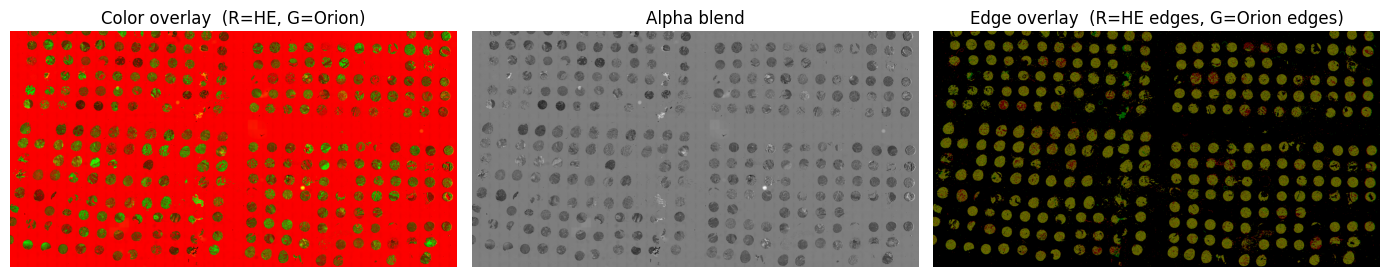

In [2]:
import numpy as np, cv2, matplotlib.pyplot as plt

# ---- 1) paths to the warped slides you just saved
he_path  = "registered_slides_aug20/HE.ome.tiff"
ori_path = "registered_slides_aug20/Orion.ome.tiff"

# ---- 2) open slide readers (instantiate the class returned by get_slide_reader)
he_reader_cls  = slide_io.get_slide_reader(he_path)
ori_reader_cls = slide_io.get_slide_reader(ori_path)
he  = he_reader_cls(src_f=he_path)
ori = ori_reader_cls(src_f=ori_path)

# ---- 3) pick a pyramid level so the long side is ~4000 px (nice for plotting)
w0, h0 = he.metadata.slide_dimensions[0]
long_side = max(w0, h0)
target = 4000
down_approx = max(1, int(round(long_side / target)))
# levels are powers of two; pick the level whose downsample is closest to down_approx
ratios = [w0 / w for (w, h) in he.metadata.slide_dimensions]
level = int(np.argmin([abs(r - down_approx) for r in ratios]))

# ---- 4) fetch overview images at that level
he_img  = he.slide2image(level=level)      # numpy array, RGB or multi-channel
ori_img = ori.slide2image(level=level)

# ---- 5) make robust 8-bit grayscale for each (works for RGB or multi-channel Orion)
def to_gray_uint8(img):
    if img.ndim == 3:
        # if >3 channels (e.g., Orion multiplex), use max-projection for quick QC
        g = img.max(axis=2) if img.shape[2] > 3 else cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        g = img
    p1, p99 = np.percentile(g, (1, 99))
    g = np.clip((g - p1) / (p99 - p1 + 1e-6), 0, 1)
    return (g * 255).astype(np.uint8)

he_gray  = to_gray_uint8(he_img)
ori_gray = to_gray_uint8(ori_img)

# If shapes differ slightly (rare after warp), resize Orion to H&E for display
if he_gray.shape != ori_gray.shape:
    ori_gray = cv2.resize(ori_gray, (he_gray.shape[1], he_gray.shape[0]),
                          interpolation=cv2.INTER_AREA)

# ---- 6) build color overlay and an alpha-blend view
overlay = np.zeros((he_gray.shape[0], he_gray.shape[1], 3), dtype=np.uint8)
overlay[..., 0] = he_gray           # Red   = H&E
overlay[..., 1] = ori_gray          # Green = Orion

blend = cv2.addWeighted(he_gray, 0.5, ori_gray, 0.5, 0)

# (Optional) edge overlay helps spot tiny misalignments
edges_he  = cv2.Canny(he_gray, 50, 150)
edges_ori = cv2.Canny(ori_gray, 50, 150)
edge_rgb = np.zeros_like(overlay)
edge_rgb[..., 0] = edges_he
edge_rgb[..., 1] = edges_ori

# ---- 7) plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 3, 1); plt.title("Color overlay  (R=HE, G=Orion)"); plt.imshow(overlay); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Alpha blend"); plt.imshow(blend, cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("Edge overlay  (R=HE edges, G=Orion edges)"); plt.imshow(edge_rgb); plt.axis('off')
plt.tight_layout(); plt.show()

In [3]:
print("H&E image shape:", he_img.shape)
print("Orion image shape:", ori_img.shape)

H&E image shape: (2768, 5248, 3)
Orion image shape: (2768, 5248, 20)


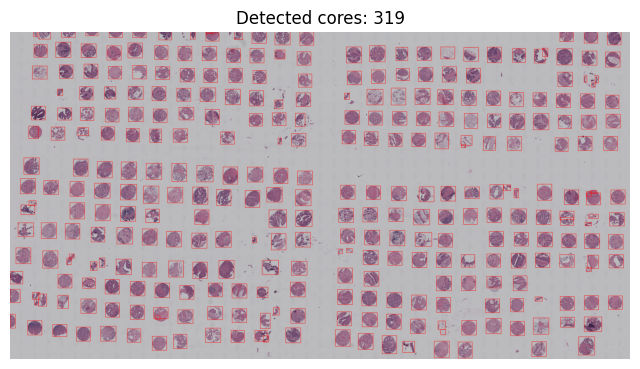

In [4]:
# --- Imports (most of these were already imported earlier) ---
import numpy as np
import cv2
from skimage import measure
import matplotlib.pyplot as plt

# 'he_img' already contains the down‑sampled H&E image at the chosen level.
# Convert it to grayscale and apply a mild blur before thresholding.
gray = cv2.cvtColor(he_img, cv2.COLOR_RGB2GRAY)
# Apply a Laplacian filter and then Otsu thresholding as suggested in the paper.
laplace = cv2.Laplacian(gray, ddepth=cv2.CV_32F)
laplace = cv2.normalize(laplace, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, binary = cv2.threshold(laplace, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Morphological closing (fill holes) and opening (remove small specks)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

# Label connected components; remove very small objects (< 10 pixels).
labels = measure.label(opened, connectivity=2)
regions = measure.regionprops(labels)
bboxes = []
areas = [r.area for r in regions if r.area > 10]  # area threshold of 10 pixels
# Compute a reasonable minimum area (e.g., lower quartile) to filter out noise.
if areas:
    q1 = np.percentile(areas, 25)
    for r in regions:
        if r.area > q1:  # keep only reasonably large components
            bboxes.append(r.bbox)  # (min_row, min_col, max_row, max_col)

# Visualise the detected bounding boxes on the down‑sampled H&E image.
overlay = he_img.copy()
for (minr, minc, maxr, maxc) in bboxes:
    cv2.rectangle(overlay, (minc, minr), (maxc, maxr), (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.title(f"Detected cores: {len(bboxes)}")
plt.imshow(overlay)
plt.axis("off")
plt.show()


In [6]:
# === Build NPY training pairs from registered OME-TIFFs (robust to pages vs bands + correct dtype) ===
# Requires: he_path, ori_path, bboxes, he_img (from previous cells)

import os, time, numpy as np, pyvips
from pathlib import Path
from collections import Counter

out_dir = Path("core_patches_npy")
out_dir.mkdir(parents=True, exist_ok=True)

# Fixed target size so every pair has the same dims and core centered.
TARGET_W = 2048
TARGET_H = 2048

# --- helpers ---
_VIPS2NP = {
    'uchar':    np.uint8,
    'char':     np.int8,
    'ushort':   np.uint16,
    'short':    np.int16,
    'uint':     np.uint32,
    'int':      np.int32,
    'float':    np.float32,
    'double':   np.float64,
    'complex':  np.complex64,
    'dpcomplex':np.complex128,
}

def vips_to_numpy(img: pyvips.Image) -> np.ndarray:
    """pyvips.Image -> np.ndarray (H, W, C) with correct dtype mapping."""
    fmt = img.format
    if fmt not in _VIPS2NP:
        raise RuntimeError(f"Unhandled VIPS pixel format: {fmt}")
    dtype = _VIPS2NP[fmt]
    mem = img.write_to_memory()
    arr = np.frombuffer(mem, dtype=dtype)
    arr = arr.reshape(img.height, img.width, img.bands)
    return arr

def clamp(v, lo, hi): 
    return max(lo, min(hi, v))

# --- open slides ---
he_slide  = pyvips.Image.new_from_file(he_path,  access="random")    # H&E (likely 8-bit, 3 bands)
ori_probe = pyvips.Image.new_from_file(ori_path, access="random")    # just to inspect fields

FULL_W, FULL_H = he_slide.width, he_slide.height

# Figure out Orion layout: 20 pages (I dimension) vs 20 interleaved bands
fields = ori_probe.get_fields()
n_pages = ori_probe.get("n-pages") if "n-pages" in fields else 1
ori_is_multi_page = (n_pages >= 20)
ori_has_20_bands  = (ori_probe.bands == 20)

if not (ori_is_multi_page or ori_has_20_bands):
    raise RuntimeError(f"Cannot find 20 channels in Orion: pages={n_pages}, bands={ori_probe.bands}")

# Pre-open Orion pages if multi-page; otherwise we’ll crop the 20-band image once
ori_pages = None
ori_img   = None
if ori_is_multi_page:
    ori_pages = [pyvips.Image.new_from_file(ori_path, page=i, access="random") for i in range(20)]
else:
    ori_img = ori_probe  # 20-band image

# --- mapping thumbnail -> level 0 ---
thumb_h, thumb_w = he_img.shape[:2]
scale_x = FULL_W / float(thumb_w)
scale_y = FULL_H / float(thumb_h)

# --- crop & save ---
saved, errs = 0, []
tic = time.time()
for idx, (min_r, min_c, max_r, max_c) in enumerate(bboxes):
    cx_thumb = (min_c + max_c) / 2.0
    cy_thumb = (min_r + max_r) / 2.0

    cx_full = int(round(cx_thumb * scale_x))
    cy_full = int(round(cy_thumb * scale_y))

    half_w = TARGET_W // 2
    half_h = TARGET_H // 2
    x0 = clamp(cx_full - half_w, 0, FULL_W - TARGET_W)
    y0 = clamp(cy_full - half_h, 0, FULL_H - TARGET_H)

    try:
        # ---- H&E crop → (H, W, 3) float32 [0,1]
        he_crop = he_slide.crop(x0, y0, TARGET_W, TARGET_H)
        he_np   = vips_to_numpy(he_crop)   # correct dtype (uint8/uint16/float, etc.)

        # Ensure 3 channels
        if he_np.ndim == 2:
            he_np = np.stack([he_np]*3, axis=-1)
        if he_np.shape[-1] > 3:  # drop alpha if present
            he_np = he_np[..., :3]

        # Normalize to [0,1] → float32
        if he_np.dtype == np.uint8:
            he_np = he_np.astype(np.float32) / 255.0
        elif he_np.dtype == np.uint16:
            he_np = he_np.astype(np.float32) / 65535.0
        else:
            he_np = he_np.astype(np.float32)

        # ---- Orion crop → (H, W, 20) float32 [0,1]
        if ori_is_multi_page:
            chans = []
            for p in ori_pages:
                roi = p.crop(x0, y0, TARGET_W, TARGET_H)
                a = vips_to_numpy(roi)  # (H,W,1) or (H,W)
                if a.ndim == 3 and a.shape[-1] == 1:
                    a = a[..., 0]
                # scale per dtype
                if a.dtype == np.uint16:
                    a = a.astype(np.float32) / 65535.0
                elif a.dtype == np.uint8:
                    a = a.astype(np.float32) / 255.0
                else:
                    a = a.astype(np.float32)
                chans.append(a)
            ori_np = np.stack(chans, axis=-1)  # (H, W, 20)
        else:
            roi = ori_img.crop(x0, y0, TARGET_W, TARGET_H)   # 20-band
            ori_np = vips_to_numpy(roi)
            # scale to [0,1]
            if ori_np.dtype == np.uint16:
                ori_np = ori_np.astype(np.float32) / 65535.0
            elif ori_np.dtype == np.uint8:
                ori_np = ori_np.astype(np.float32) / 255.0
            else:
                ori_np = ori_np.astype(np.float32)

        # Save NPYs
        base = f"core_{idx:03d}"
        np.save(out_dir / f"{base}_HE.npy",    he_np,  allow_pickle=False)   # (H,W,3)
        np.save(out_dir / f"{base}_ORION.npy", ori_np, allow_pickle=False)   # (H,W,20)

        saved += 1
        if (idx + 1) % 25 == 0:
            print(f"…saved {idx+1}/{len(bboxes)} cores")
    except Exception as e:
        errs.append((idx, str(e)))

print(f"Saved {saved}/{len(bboxes)} pairs to '{out_dir}'.  Errors: {len(errs)}; time: {time.time()-tic:.1f}s")
if errs:
    print("First few errors:", errs[:5])

# quick summary
from glob import glob
he_n = len(glob(str(out_dir / "*_HE.npy")))
or_n = len(glob(str(out_dir / "*_ORION.npy")))
print(f"NPY count: HE={he_n} ORION={or_n}")

# channel sanity on a sample
counts = Counter()
for p in glob(str(out_dir / "*_ORION.npy"))[:25]:
    a = np.load(p, mmap_mode="r")
    counts[a.shape[-1]] += 1
print("Orion channel counts in saved NPYs:", counts)  # expect Counter({20: ...})


…saved 25/319 cores
…saved 50/319 cores
…saved 75/319 cores
…saved 100/319 cores
…saved 125/319 cores
…saved 150/319 cores
…saved 175/319 cores
…saved 200/319 cores
…saved 225/319 cores
…saved 250/319 cores
…saved 275/319 cores
…saved 300/319 cores
Saved 319/319 pairs to 'core_patches_npy'.  Errors: 0; time: 2011.7s
NPY count: HE=319 ORION=319
Orion channel counts in saved NPYs: Counter({20: 25})


In [7]:
# Paths
pairs_dir = "core_patches_npy"

import os, glob, numpy as np
from collections import Counter

he_paths  = sorted(glob.glob(os.path.join(pairs_dir, "core_*_HE.npy")))
ori_paths = sorted(glob.glob(os.path.join(pairs_dir, "core_*_ORION.npy")))
print(f"Found HE={len(he_paths)}, ORION={len(ori_paths)}")

# 1) Pairing check by basename
he_bases  = [os.path.basename(p).replace("_HE.npy","") for p in he_paths]
ori_bases = [os.path.basename(p).replace("_ORION.npy","") for p in ori_paths]
missing_in_ori = sorted(set(he_bases) - set(ori_bases))
missing_in_he  = sorted(set(ori_bases) - set(he_bases))
print("Missing in Orion:", missing_in_ori[:5], "..." if len(missing_in_ori)>5 else "")
print("Missing in H&E  :", missing_in_he[:5],  "..." if len(missing_in_he)>5 else "")

# 2) Shape & dtype sweep (mmap to stay light)
sh_HE  = Counter()
sh_ORI = Counter()
dt_HE  = Counter()
dt_ORI = Counter()
mismatches = []

for hp in he_paths:
    base = os.path.basename(hp).replace("_HE.npy","")
    op = os.path.join(pairs_dir, f"{base}_ORION.npy")
    if not os.path.exists(op):
        mismatches.append((base, "missing_orion"))
        continue
    
    he  = np.load(hp, mmap_mode="r")
    ori = np.load(op, mmap_mode="r")
    
    sh_HE.update([he.shape])
    sh_ORI.update([ori.shape])
    dt_HE.update([he.dtype])
    dt_ORI.update([ori.dtype])
    
    # Expect HE: (H,W,3), ORI: (H,W,20)
    if he.ndim != 3 or he.shape[2] < 3:
        mismatches.append((base, f"HE shape {he.shape}"))
    if ori.ndim != 3 or ori.shape[2] != 20:
        # Accept (20,H,W) too (will transpose in plotting if needed)
        if not (ori.ndim == 3 and ori.shape[0] == 20):
            mismatches.append((base, f"ORION shape {ori.shape}"))

print("\nUnique HE shapes  :", dict(sh_HE))
print("Unique ORION shapes:", dict(sh_ORI))
print("HE dtypes          :", dict(dt_HE))
print("ORION dtypes       :", dict(dt_ORI))
print("Problem pairs      :", len(mismatches))
if mismatches:
    print("First few:", mismatches[:5])

# 3) Count channels across *all* Orion npys (not just a sample)
ch_counts = Counter()
for op in ori_paths:
    a = np.load(op, mmap_mode="r")
    if a.ndim == 3:
        ch = a.shape[2] if a.shape[2] in (1, 3, 20) else a.shape[0]
        ch_counts.update([ch])
print("Orion channel counts across ALL:", ch_counts)


Found HE=319, ORION=319
Missing in Orion: [] 
Missing in H&E  : [] 

Unique HE shapes  : {(2048, 2048, 3): 319}
Unique ORION shapes: {(2048, 2048, 20): 319}
HE dtypes          : {dtype('float32'): 319}
ORION dtypes       : {dtype('float32'): 319}
Problem pairs      : 0
Orion channel counts across ALL: Counter({20: 319})


Showing core_205
Saved: qc_outputs/core_205_fluorescence_grid.png


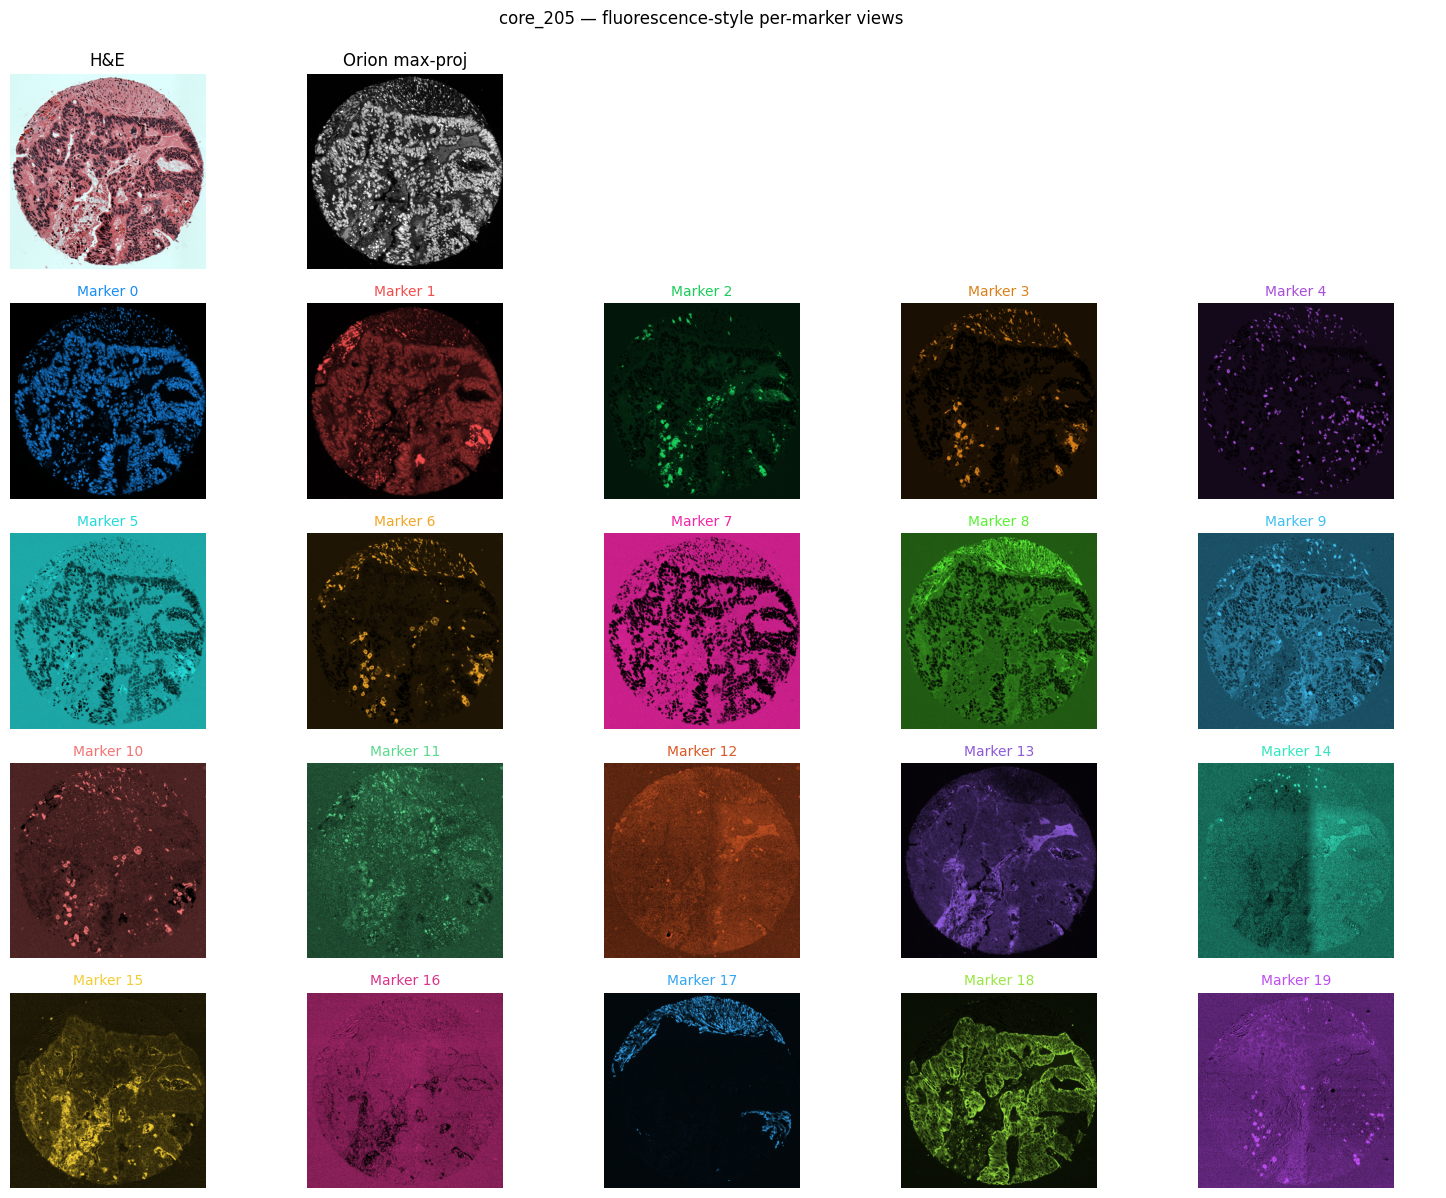

Showing core_153
Saved: qc_outputs/core_153_fluorescence_grid.png


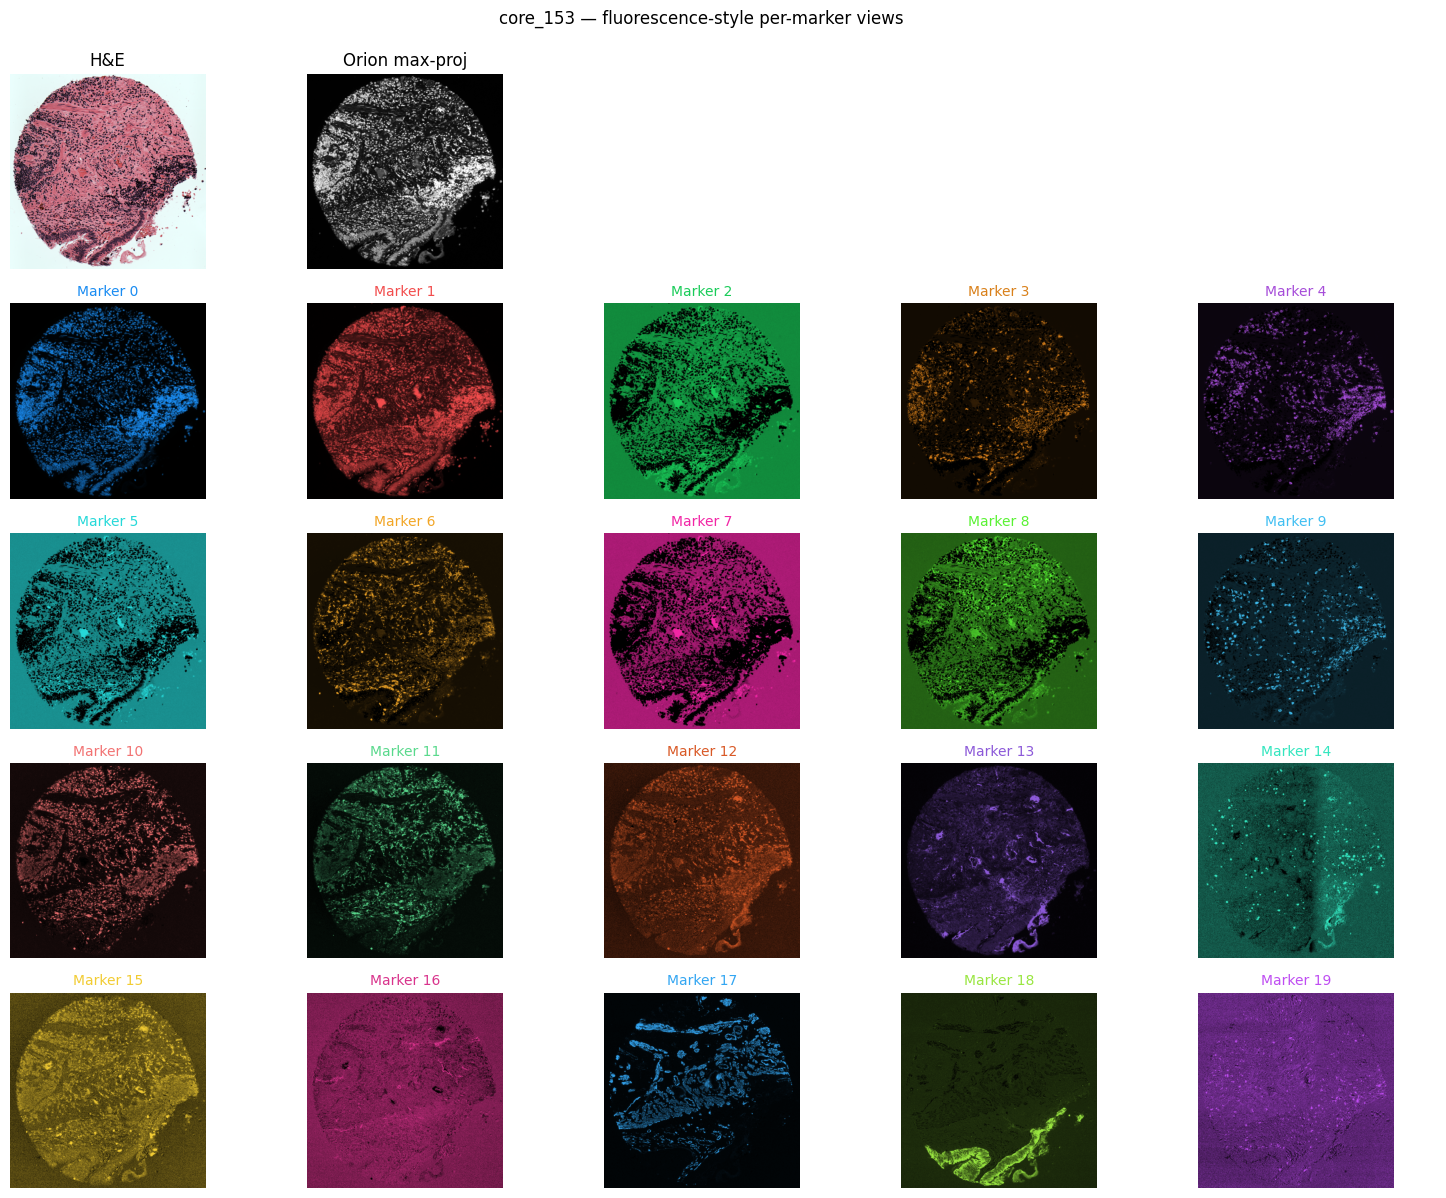

Showing core_303
Saved: qc_outputs/core_303_fluorescence_grid.png


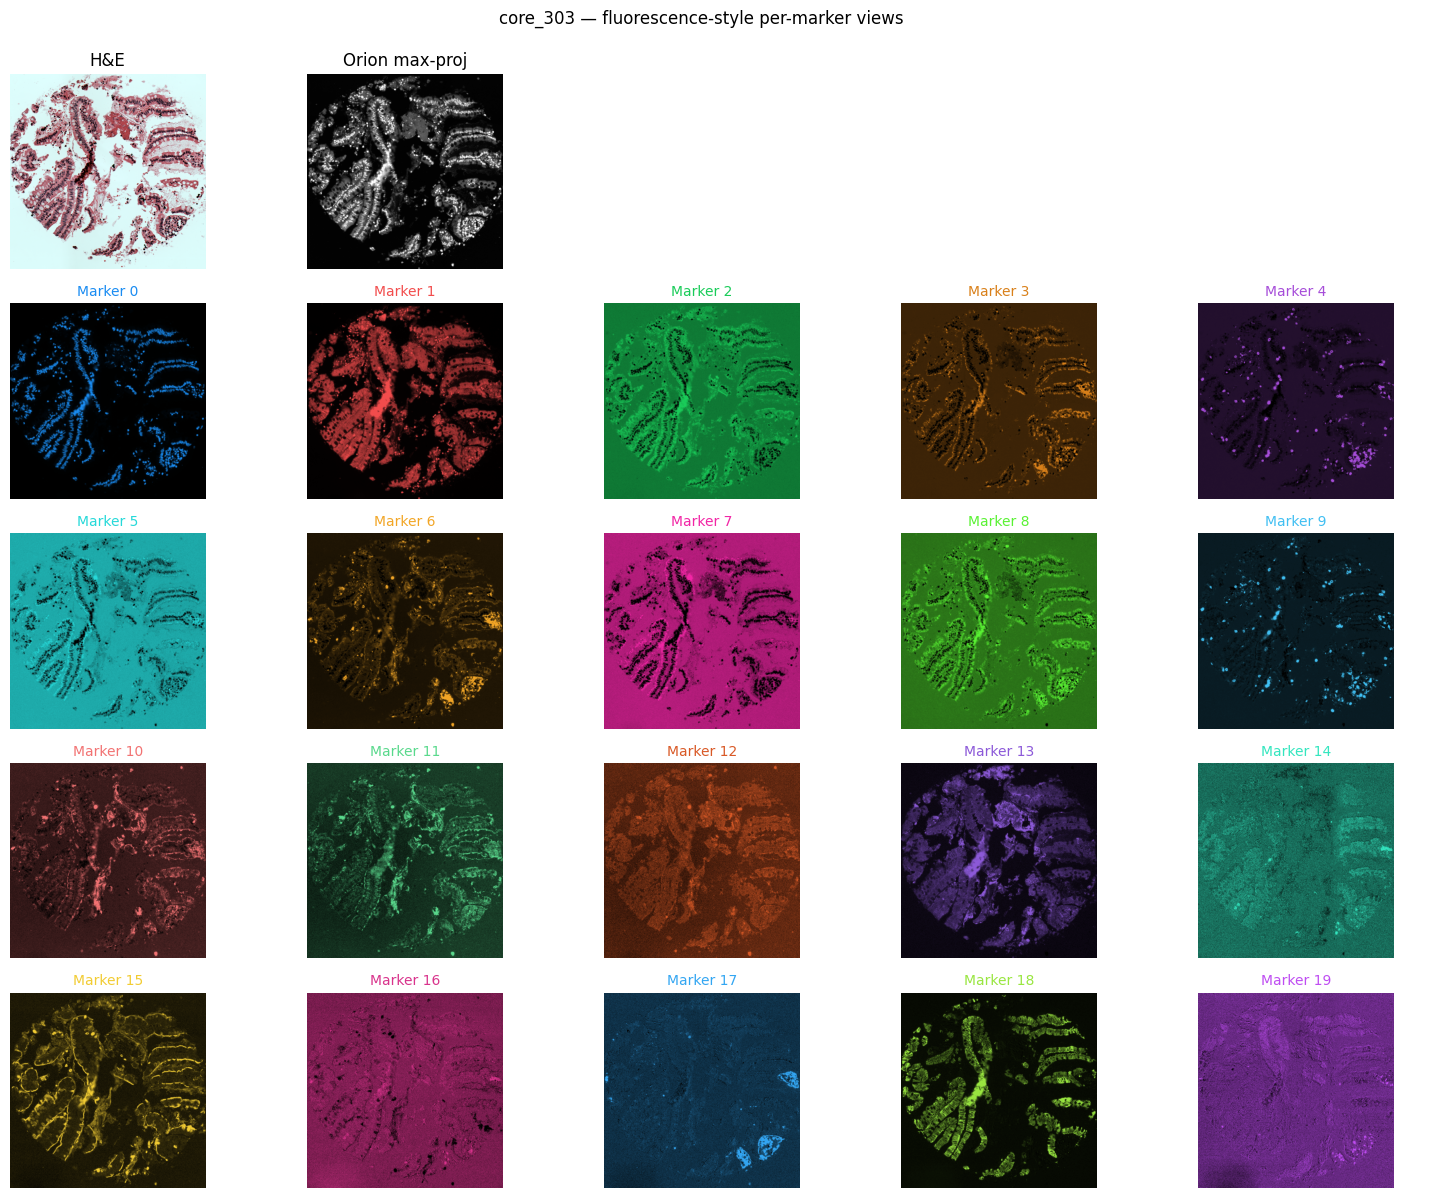

In [8]:
import os, glob, random, numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pairs_dir = "core_patches_npy"
save_dir  = "qc_outputs"
os.makedirs(save_dir, exist_ok=True)

# Optional: provide real marker names (len=20) if you have them.
marker_names = [f"Marker {i}" for i in range(20)]
dapi_idx = None  # set to e.g. 0 if you know DAPI index

def robust_norm(img, p1=1, p99=99, eps=1e-6):
    lo, hi = np.percentile(img, (p1, p99))
    if hi <= lo: 
        return np.zeros_like(img, dtype=np.float32)
    return np.clip((img - lo) / (hi - lo + eps), 0, 1).astype(np.float32)

def make_tint_cmap(rgb, name):
    # black -> tint(rgb)
    cdict = {
        'red':   ((0, 0, 0), (1, rgb[0], rgb[0])),
        'green': ((0, 0, 0), (1, rgb[1], rgb[1])),
        'blue':  ((0, 0, 0), (1, rgb[2], rgb[2])),
    }
    return LinearSegmentedColormap(name, cdict)

base_colors = [
    (0.10,0.55,0.95), (0.95,0.30,0.30), (0.10,0.80,0.35), (0.85,0.50,0.10), (0.65,0.30,0.85),
    (0.15,0.85,0.85), (0.95,0.65,0.15), (0.95,0.15,0.65), (0.35,0.95,0.20), (0.25,0.75,0.95),
    (0.95,0.45,0.45), (0.35,0.85,0.55), (0.85,0.35,0.15), (0.55,0.35,0.85), (0.20,0.90,0.75),
    (0.95,0.80,0.20), (0.85,0.20,0.55), (0.20,0.65,0.95), (0.60,0.90,0.25), (0.75,0.30,0.95),
]
cmaps = [make_tint_cmap(rgb, f"m{i}") for i, rgb in enumerate(base_colors)]

def load_pair(base):
    he  = np.load(os.path.join(pairs_dir, f"{base}_HE.npy")).astype(np.float32)        # (H,W,3)
    ori = np.load(os.path.join(pairs_dir, f"{base}_ORION.npy")).astype(np.float32)      # (H,W,20) or (20,H,W)
    if ori.shape[0] == 20 and ori.shape[-1] != 20:   # (20,H,W) -> (H,W,20)
        ori = np.transpose(ori, (1, 2, 0))
    return he, ori

def he_for_display(he):
    he_disp = he.copy()
    for c in range(min(3, he_disp.shape[2])):
        he_disp[..., c] = robust_norm(he_disp[..., c])
    return he_disp

def render_fluo_grid(base, gamma=0.85, save=True):
    he, ori = load_pair(base)
    he_disp = he_for_display(he)
    max_proj = robust_norm(ori.max(axis=2))  # (H,W)

    fig, ax = plt.subplots(5, 5, figsize=(15, 12))
    # Row 0: H&E and max-projection
    ax[0,0].imshow(he_disp); ax[0,0].set_title("H&E"); ax[0,0].axis('off')
    if dapi_idx is not None:
        dapi = robust_norm(ori[..., dapi_idx]) ** gamma
        ax[0,1].imshow(dapi, cmap=make_tint_cmap((0.2,0.5,1.0), "DAPI"))
        ax[0,1].set_title("DAPI"); ax[0,1].axis('off')
    else:
        ax[0,1].imshow(max_proj**gamma, cmap='gray'); ax[0,1].set_title("Orion max-proj"); ax[0,1].axis('off')
    for j in (2,3,4):
        ax[0,j].axis('off')

    # Rows 1..4: the 20 markers as monochrome “fluorescence”
    idx = 0
    for r in range(1,5):
        for c in range(5):
            ch = robust_norm(ori[..., idx]) ** gamma
            ax[r,c].imshow(ch, cmap=cmaps[idx], vmin=0, vmax=1)
            name = marker_names[idx] if idx < len(marker_names) else f"Marker {idx}"
            ax[r,c].set_title(name, color=base_colors[idx], fontsize=10)
            ax[r,c].axis('off')
            idx += 1
            if idx >= 20: break
        if idx >= 20: break

    plt.suptitle(f"{base} — fluorescence-style per-marker views", y=0.995)
    plt.tight_layout()
    if save:
        out = os.path.join(save_dir, f"{base}_fluorescence_grid.png")
        plt.savefig(out, dpi=150, bbox_inches='tight')
        print("Saved:", out)
    plt.show()

# Show 3 random cores
he_paths = sorted(glob.glob(os.path.join(pairs_dir, "core_*_HE.npy")))
bases = [os.path.basename(p).replace("_HE.npy","") for p in he_paths]
for b in random.sample(bases, k=min(3, len(bases))):
    print("Showing", b)
    render_fluo_grid(b)


In [9]:
import os, glob, numpy as np
import pandas as pd

pairs_dir = "core_patches_npy"
ori_paths = sorted(glob.glob(os.path.join(pairs_dir, "core_*_ORION.npy")))

# Sample up to N cores for speed
N = min(64, len(ori_paths))
sample = np.linspace(0, len(ori_paths)-1, N, dtype=int)

stats = []
for i in sample:
    a = np.load(ori_paths[i], mmap_mode="r")
    # accept (20,H,W) or (H,W,20); convert to (20,-1)
    if a.ndim == 3 and a.shape[0] == 20:
        a = np.transpose(a, (1,2,0))
    H, W, C = a.shape
    flat = a.reshape(-1, C)
    s = {
        "file": os.path.basename(ori_paths[i]),
        "nonzero_frac_mean": (flat>0).mean(axis=0).mean(),
        "nonzero_frac_min":  (flat>0).mean(axis=0).min(),
        "nonzero_frac_max":  (flat>0).mean(axis=0).max(),
        "p99_mean":          np.percentile(flat, 99, axis=0).mean(),
        "p99_min":           np.percentile(flat, 99, axis=0).min(),
        "p99_max":           np.percentile(flat, 99, axis=0).max(),
    }
    stats.append(s)

df = pd.DataFrame(stats)
print(df.describe().T)

# Optional: flag suspicious files (e.g., many zeros)
sus = df[df["nonzero_frac_mean"] < 0.01]
print(f"\nSuspicious (very sparse) files: {len(sus)}")
print(sus.head(10))


                   count      mean       std       min       25%       50%  \
nonzero_frac_mean   64.0  0.985950  0.015527  0.916265  0.980744  0.990168   
nonzero_frac_min    64.0  0.902413  0.081702  0.663671  0.852203  0.926411   
nonzero_frac_max    64.0  0.999988  0.000075  0.999441  1.000000  1.000000   
p99_mean            64.0  0.029649  0.008740  0.007440  0.024319  0.029450   
p99_min             64.0  0.003525  0.000145  0.003326  0.003429  0.003494   
p99_max             64.0  0.199112  0.067337  0.027451  0.160750  0.209148   

                        75%       max  
nonzero_frac_mean  0.996280  0.999686  
nonzero_frac_min   0.963254  0.997903  
nonzero_frac_max   1.000000  1.000000  
p99_mean           0.034688  0.056121  
p99_min            0.003586  0.004028  
p99_max            0.241566  0.368963  

Suspicious (very sparse) files: 0
Empty DataFrame
Columns: [file, nonzero_frac_mean, nonzero_frac_min, nonzero_frac_max, p99_mean, p99_min, p99_max]
Index: []
